In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import signal, stats
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

# Paths
INPUT_DIR = 'Wav_data'  # Directory with filtered WAV files
OUTPUT_DIR = 'frequency_range_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Analysis parameters (mirror GUI defaults)
SAMPLING_RATE = 100000  # Hz
MIN_FREQ = 200          # Hz (analysis start)
MAX_FREQ = 1000         # Hz (analysis end)
PSD_NPERSEG = 4096      # Welch window (matches GUI)

# Threshold parameters
THRESHOLD_METHOD = 'freq_range'   # 'freq_range', 'std', 'percentile', 'absolute'
STD_MULTIPLIER = 2.0              # For std method fallback
BASELINE_STD_MULTIPLIER = 2.0     # Std multiplier inside baseline frequency band
PERCENTILE_THRESHOLD = 95         # For percentile method
ABSOLUTE_THRESHOLD = 0.01         # For absolute method
BASELINE_FREQ_MIN = 800           # Baseline band lower bound
BASELINE_FREQ_MAX = 1000          # Baseline band upper bound

print("=" * 60)
print("Frequency Range Analysis Setup")
print("=" * 60)
print(f"Input Directory: {INPUT_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Sampling Rate: {SAMPLING_RATE} Hz")
print(f"Frequency Range: {MIN_FREQ}-{MAX_FREQ} Hz")
print(f"Baseline Band: {BASELINE_FREQ_MIN}-{BASELINE_FREQ_MAX} Hz")
print(f"Threshold Method: {THRESHOLD_METHOD} (baseline std x {BASELINE_STD_MULTIPLIER})")
print("\nUse pre-processed WAVs; GUI and notebook now share defaults.")
print("=" * 60)

Frequency Range Analysis Setup
Input Directory: Wav_data_all
Output Directory: frequency_range_analysis
Sampling Rate: 100000 Hz
Frequency Range: 0-1000 Hz
Threshold Method: std



## Step 1: Load WAV Files

WAV files are already filtered (0-1000 Hz) and normalized.
Place them in `Wav_data_mech/{species}/` (optionally `/{direction}/`).

In [3]:
def load_wav_file(filepath):
    """
    Load WAV file (already filtered and normalized)
    Returns: data array and sampling rate
    """
    data, sr = librosa.load(filepath, sr=SAMPLING_RATE)
    
    if sr != SAMPLING_RATE:
        print(f"Warning: Expected {SAMPLING_RATE} Hz, got {sr} Hz")
    
    return data, sr

# Scan for WAV files
test_files = []
for root, dirs, files in os.walk(INPUT_DIR):
    for fname in files:
        if fname.lower().endswith('.wav'):
            test_files.append(os.path.join(root, fname))
            
print(f"Found {len(test_files)} WAV files")

if test_files:
    # Group by species and direction
    species_dirs = {}
    for f in test_files:
        parts = f.split(os.sep)
        if len(parts) >= 3:
            species = parts[-3]  # Wav_data_all/{species}/{direction}/file.wav
            direction = parts[-2]
            key = f"{species}/{direction}"
            species_dirs[key] = species_dirs.get(key, 0) + 1
    
    print("\nFiles by species and direction:")
    for key, count in sorted(species_dirs.items()):
        print(f"  {key}: {count} files")
    
    # Test load one file
    print(f"\nTesting first file: {os.path.basename(test_files[0])}")
    data, sr = load_wav_file(test_files[0])
    print(f"  Data shape: {data.shape}")
    print(f"  Sampling rate: {sr} Hz")
    print(f"  Duration: {len(data)/sr:.3f} seconds")
    print(f"  Data range: [{data.min():.4f}, {data.max():.4f}]")
else:
    print("\n❌ No WAV files found!")
    print("   Please run wav_analysis.ipynb first to generate WAV files.")

Found 788 WAV files

Files by species and direction:
  Culex/backward: 172 files
  Culex/forward: 172 files
  Culex/forward - Copy: 172 files
  aedes aegypti/backward: 136 files
  aedes aegypti/forward: 136 files

Testing first file: 2025_04_04_NI_Cxpp_male_mosq3_-30V_No injection_5 min_279-28_LSwAv_326_backward_2.wav
  Data shape: (110000,)
  Sampling rate: 100000 Hz
  Duration: 1.100 seconds
  Data range: [-1.0000, 0.9947]
  Data shape: (110000,)
  Sampling rate: 100000 Hz
  Duration: 1.100 seconds
  Data range: [-1.0000, 0.9947]


## Step 2: Compute Power Spectrum

In [ ]:
def compute_power_spectrum(data, fs, nperseg=PSD_NPERSEG):
    """Compute power spectral density using Welch's method."""
    freqs, psd = signal.welch(data, fs=fs, nperseg=nperseg)
    mask = (freqs >= MIN_FREQ) & (freqs <= MAX_FREQ)
    return freqs[mask], psd[mask]

def compute_spectrogram(data, fs, nperseg=PSD_NPERSEG, noverlap=None):
    """Compute time-frequency representation for quick QA."""
    if noverlap is None:
        noverlap = nperseg // 2
    freqs, times, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    mask = (freqs >= MIN_FREQ) & (freqs <= MAX_FREQ)
    freqs = freqs[mask]
    Sxx = Sxx[mask, :]
    Sxx_db = 10 * np.log10(Sxx + 1e-12)
    return times, freqs, Sxx_db

# Test computation
if test_files:
    data, fs = load_wav_file(test_files[0])
    freqs, psd = compute_power_spectrum(data, fs)
    times, spec_freqs, Sxx = compute_spectrogram(data, fs)
    print(f"\nPower spectrum computed:")
    print(f"  Frequency range: {freqs.min():.1f} - {freqs.max():.1f} Hz")
    print(f"  Number of frequency bins: {len(freqs)}")
    print(f"  Spectrogram shape: {Sxx.shape} (freq × time)")


Power spectrum computed:
  Frequency range: 0.0 - 976.6 Hz
  Number of frequency bins: 11
  Spectrogram shape: (11, 213) (freq × time)


## Step 3: Calculate Response Baseline and Threshold

In [ ]:
def calculate_baseline_threshold(power_spectrum, freqs=None, method=THRESHOLD_METHOD, **kwargs):
    """Calculate baseline and threshold for response detection."""
    method = method or THRESHOLD_METHOD
    if method == 'freq_range':
        baseline_min = kwargs.get('baseline_min', BASELINE_FREQ_MIN)
        baseline_max = kwargs.get('baseline_max', BASELINE_FREQ_MAX)
        baseline_std_mult = kwargs.get('baseline_std_multiplier', BASELINE_STD_MULTIPLIER)
        if freqs is None:
            baseline = np.mean(power_spectrum)
            std = np.std(power_spectrum)
            threshold = baseline + STD_MULTIPLIER * std
        else:
            mask = (freqs >= baseline_min) & (freqs <= baseline_max)
            if np.any(mask):
                baseline_region = power_spectrum[mask]
                baseline = float(np.mean(baseline_region))
                baseline_std = float(np.std(baseline_region))
                threshold = baseline + baseline_std_mult * baseline_std
            else:
                baseline = np.mean(power_spectrum)
                std = np.std(power_spectrum)
                threshold = baseline + STD_MULTIPLIER * std

    elif method == 'std':
        multiplier = kwargs.get('std_multiplier', STD_MULTIPLIER)
        baseline = np.mean(power_spectrum)
        std = np.std(power_spectrum)
        threshold = baseline + multiplier * std

    elif method == 'percentile':
        percentile = kwargs.get('percentile', PERCENTILE_THRESHOLD)
        baseline = np.median(power_spectrum)
        threshold = np.percentile(power_spectrum, percentile)

    elif method == 'absolute':
        baseline = np.min(power_spectrum)
        threshold = kwargs.get('absolute_threshold', ABSOLUTE_THRESHOLD)

    else:
        raise ValueError(f"Unknown threshold method: {method}")

    return baseline, threshold

def find_response_regions(freqs, power, threshold):
    """Find continuous frequency regions where power exceeds threshold."""
    above_threshold = power > threshold

    # Fallback to -3 dB mask if nothing crosses threshold
    if not np.any(above_threshold):
        peak_power = np.max(power)
        peak_power_db = 10 * np.log10(peak_power + 1e-12)
        power_db = 10 * np.log10(power + 1e-12)
        threshold_3db = peak_power_db - 3
        above_threshold = power_db > threshold_3db

    regions = []
    in_region = False
    start_idx = None

    for i, is_above in enumerate(above_threshold):
        if is_above and not in_region:
            start_idx = i
            in_region = True
        elif not is_above and in_region:
            end_idx = i - 1
            if end_idx > start_idx:
                freq_start = freqs[start_idx]
                freq_end = freqs[end_idx]
                mean_power = np.mean(power[start_idx:end_idx+1])
                regions.append((freq_start, freq_end, mean_power))
            in_region = False

    if in_region and start_idx < len(freqs) - 1:
        freq_start = freqs[start_idx]
        freq_end = freqs[-1]
        mean_power = np.mean(power[start_idx:])
        regions.append((freq_start, freq_end, mean_power))

    return regions

# Test threshold calculation
if test_files:
    baseline, threshold = calculate_baseline_threshold(
        psd,
        freqs=freqs,
        method=THRESHOLD_METHOD,
        std_multiplier=STD_MULTIPLIER,
        baseline_std_multiplier=BASELINE_STD_MULTIPLIER,
        baseline_min=BASELINE_FREQ_MIN,
        baseline_max=BASELINE_FREQ_MAX,
    )
    regions = find_response_regions(freqs, psd, threshold)
    print(f"\nThreshold Analysis:")
    print(f"  Baseline power: {baseline:.6f}")
    print(f"  Threshold: {threshold:.6f}")
    print(f"  Found {len(regions)} response region(s):")
    for i, (f_start, f_end, power) in enumerate(regions, 1):
        print(f"    Region {i}: {f_start:.1f} - {f_end:.1f} Hz (BW: {f_end-f_start:.1f} Hz)")


Threshold Analysis:
  Baseline power: 0.000098
  Threshold: 0.000350
  Found 1 response region(s):
    Region 1: 390.6 - 390.6 Hz (BW: 0.0 Hz)


## Step 4: Extract Comprehensive Tuning Features

In [ ]:
def extract_tuning_features(freqs, power, baseline, threshold):
    """Extract comprehensive tuning curve features (GUI-parity)."""
    features = {}
    peak_idx = int(np.argmax(power))
    features['peak_frequency'] = float(freqs[peak_idx])
    features['peak_power'] = float(power[peak_idx])
    features['baseline'] = float(baseline)
    features['threshold'] = float(threshold)

    regions = find_response_regions(freqs, power, threshold)
    features['num_response_regions'] = len(regions)
    features['response_regions'] = regions

    for idx, (freq_start, freq_end, mean_power) in enumerate(regions):
        features[f'range_{idx+1}_start'] = float(freq_start)
        features[f'range_{idx+1}_end'] = float(freq_end)
        features[f'range_{idx+1}_bandwidth'] = float(freq_end - freq_start)
        features[f'range_{idx+1}_mean_power'] = float(mean_power)

    features['_detection_baseline'] = float(baseline)
    features['_detection_threshold'] = float(threshold)

    if features['peak_power'] <= 0:
        for key in ['freq_range_start', 'freq_range_end', 'freq_range_bandwidth', 'bandwidth_3dB',
                    'bandwidth_10dB', 'Q_factor', 'Q3dB', 'Q10dB', 'response_intensity',
                    'response_intensity_db', 'freq_range_mean_power']:
            features[key] = np.nan
        return features

    peak_power_db = 10 * np.log10(features['peak_power'])
    with np.errstate(divide='ignore', invalid='ignore'):
        power_db = np.where(power > 0, 10 * np.log10(power), -np.inf)

    # -3dB region used for freq_range_* and Q
    threshold_3db = peak_power_db - 3
    above_3db = power_db > threshold_3db
    if np.any(above_3db):
        indices_3db = np.where(above_3db)[0]
        features['freq_range_start'] = float(freqs[indices_3db[0]])
        features['freq_range_end'] = float(freqs[indices_3db[-1]])
        features['freq_range_bandwidth'] = float(freqs[indices_3db[-1]] - freqs[indices_3db[0]])
        features['bandwidth_3dB'] = features['freq_range_bandwidth']
        features['Q_factor'] = (features['peak_frequency'] / features['freq_range_bandwidth']
                                 if features['freq_range_bandwidth'] > 0 else np.nan)
        features['Q3dB'] = features['Q_factor']
    else:
        features['freq_range_start'] = np.nan
        features['freq_range_end'] = np.nan
        features['freq_range_bandwidth'] = np.nan
        features['bandwidth_3dB'] = np.nan
        features['Q_factor'] = np.nan
        features['Q3dB'] = np.nan

    # -10dB metrics
    threshold_10db = peak_power_db - 10
    above_10db = power_db > threshold_10db
    if np.any(above_10db):
        indices_10db = np.where(above_10db)[0]
        bw_10db = float(freqs[indices_10db[-1]] - freqs[indices_10db[0]])
        features['bandwidth_10dB'] = bw_10db
        features['Q10dB'] = float(features['peak_frequency'] / bw_10db) if bw_10db > 0 else np.nan
    else:
        features['bandwidth_10dB'] = np.nan
        features['Q10dB'] = np.nan

    if baseline > 0:
        features['response_intensity'] = float(features['peak_power'] / baseline)
        features['response_intensity_db'] = float(10 * np.log10(features['response_intensity']))
    else:
        features['response_intensity'] = np.nan
        features['response_intensity_db'] = np.nan

    if not np.isnan(features['freq_range_start']) and not np.isnan(features['freq_range_end']):
        in_range = (freqs >= features['freq_range_start']) & (freqs <= features['freq_range_end'])
        features['freq_range_mean_power'] = float(np.mean(power[in_range]))
    else:
        features['freq_range_mean_power'] = np.nan

    return features

# Test feature extraction
if test_files:
    features = extract_tuning_features(freqs, psd, baseline, threshold)
    print("\n" + "=" * 60)
    print("EXTRACTED MECHANICAL TUNING FEATURES")
    print("=" * 60)
    print(f"Peak Frequency (RED):      {features['peak_frequency']:.2f} Hz")
    print(f"Range Start (ORANGE):      {features['freq_range_start']:.2f} Hz")
    print(f"Range End (ORANGE):        {features['freq_range_end']:.2f} Hz")
    print(f"Bandwidth:                 {features['freq_range_bandwidth']:.2f} Hz")
    print(f"Baseline:                  {features['baseline']:.6f}")
    print(f"Threshold:                 {features['threshold']:.6f}")
    print(f"Q-factor:                  {features['Q_factor']:.2f}")
    print(f"Response Intensity:        {features['response_intensity_db']:.2f} dB")
    print(f"Response Regions:          {features['num_response_regions']}")
    print("=" * 60)


EXTRACTED TUNING FEATURES
Peak Frequency (RED):      390.62 Hz
Range Start (ORANGE):      390.62 Hz
Range End (ORANGE):        390.62 Hz
Bandwidth:                 0.00 Hz
Baseline (BLUE):           0.000098
Threshold (BLUE):          0.000350
Q-factor:                  nan
Response Intensity:        5.59 dB


## Step 5: Visualization (Matching Your Diagram)


Generating visualization...
  → Saved: example_tuning_analysis.png
  → Saved: example_tuning_analysis.png


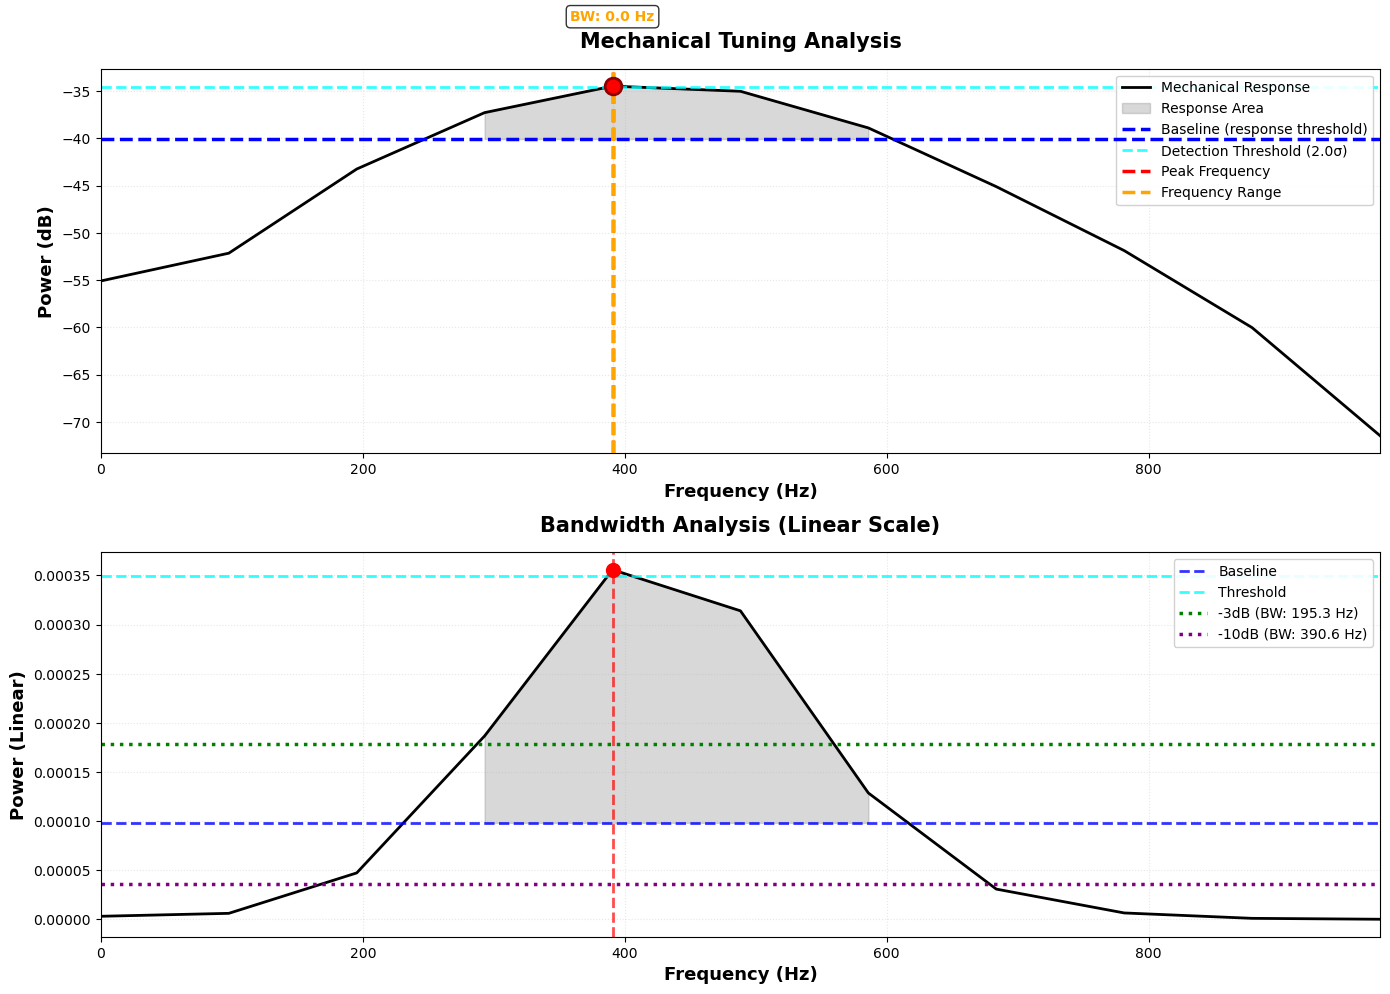

In [ ]:
def plot_tuning_analysis(freqs, power, features, filename=None):
    """Plot tuning analysis with GUI-parity styling."""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    power_db = 10 * np.log10(power + 1e-12)
    baseline_db = 10 * np.log10(features['baseline'] + 1e-12)
    threshold_db = 10 * np.log10(features['threshold'] + 1e-12)

    # Plot 1: dB scale
    ax1 = axes[0]
    ax1.plot(freqs, power_db, 'k-', linewidth=2, label='Mechanical Response')
    ax1.fill_between(freqs, power_db, baseline_db, where=(power_db >= baseline_db),
                     alpha=0.3, color='gray', label='Response Area')

    ax1.axhline(baseline_db, color='blue', linestyle='--', linewidth=2.5,
                label='Baseline (noise floor)', zorder=10)
    ax1.axhline(threshold_db, color='cyan', linestyle='--', linewidth=2,
                label=f'Detection Threshold ({BASELINE_STD_MULTIPLIER}σ)', alpha=0.8)

    peak_freq = features['peak_frequency']
    peak_power_db = 10 * np.log10(features['peak_power'] + 1e-12)
    ax1.axvline(peak_freq, color='red', linestyle='--', linewidth=2.5,
                label='Peak Frequency', zorder=10)
    ax1.plot(peak_freq, peak_power_db, 'ro', markersize=12, zorder=15,
             markeredgecolor='darkred', markeredgewidth=2)

    # Shade all detected response regions (orange)
    for freq_start, freq_end, _ in features.get('response_regions', []):
        ax1.axvspan(freq_start, freq_end, alpha=0.15, color='orange', zorder=5)
        ax1.axvline(freq_start, color='orange', linestyle='--', linewidth=2.5, zorder=10)
        ax1.axvline(freq_end, color='orange', linestyle='--', linewidth=2.5, zorder=10)

    # 3 dB bandwidth annotation (freq_range_*)
    if not np.isnan(features['freq_range_start']):
        mid_freq = (features['freq_range_start'] + features['freq_range_end']) / 2
        ax1.annotate('', xy=(features['freq_range_start'], threshold_db + 5),
                     xytext=(features['freq_range_end'], threshold_db + 5),
                     arrowprops=dict(arrowstyle='<->', color='orange', lw=2))
        ax1.text(mid_freq, threshold_db + 7,
                 f"BW: {features['freq_range_bandwidth']:.1f} Hz",
                 ha='center', fontsize=10, fontweight='bold', color='orange',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax1.set_xlabel('Frequency (Hz)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Power (dB)', fontsize=13, fontweight='bold')
    ax1.set_title('Mechanical Tuning Analysis', fontsize=15, fontweight='bold', pad=15)
    ax1.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle=':')
    ax1.set_xlim(freqs[0], freqs[-1])

    # Plot 2: Linear scale
    ax2 = axes[1]
    ax2.plot(freqs, power, 'k-', linewidth=2)
    ax2.fill_between(freqs, power, features['baseline'], where=(power >= features['baseline']),
                     alpha=0.3, color='gray')
    ax2.axhline(features['baseline'], color='blue', linestyle='--', linewidth=2, alpha=0.8, label='Baseline')
    ax2.axhline(features['threshold'], color='cyan', linestyle='--', linewidth=2, alpha=0.8, label='Threshold')

    peak_power = features['peak_power']
    if not np.isnan(features['bandwidth_3dB']):
        level_3db = peak_power * 10**(-3/10)
        ax2.axhline(level_3db, color='green', linestyle=':', linewidth=2.5,
                    label=f'-3dB (BW: {features["bandwidth_3dB"]:.1f} Hz)')
    if not np.isnan(features['bandwidth_10dB']):
        level_10db = peak_power * 10**(-10/10)
        ax2.axhline(level_10db, color='purple', linestyle=':', linewidth=2.5,
                    label=f'-10dB (BW: {features["bandwidth_10dB"]:.1f} Hz)')

    ax2.axvline(peak_freq, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.plot(peak_freq, peak_power, 'ro', markersize=10, zorder=10)

    for freq_start, freq_end, _ in features.get('response_regions', []):
        ax2.axvspan(freq_start, freq_end, alpha=0.12, color='orange', zorder=5)

    ax2.set_xlabel('Frequency (Hz)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Power (Linear)', fontsize=13, fontweight='bold')
    ax2.set_title('Bandwidth Analysis (Linear Scale)', fontsize=15, fontweight='bold', pad=15)
    ax2.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle=':')
    ax2.set_xlim(freqs[0], freqs[-1])

    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  -> Saved: {os.path.basename(filename)}")

    return fig

# Test visualization
if test_files:
    print("\nGenerating visualization...")
    plot_filename = os.path.join(OUTPUT_DIR, 'example_tuning_analysis.png')
    fig = plot_tuning_analysis(freqs, psd, features, plot_filename)
    plt.show()

## Step 5b: Waveform View (GUI Parity)

Visualise the time-domain signal with the same response regions used in the frequency plot. Orange shading shows amplitude segments above the baseline band (mean ± 0.5σ).

In [ ]:
def plot_waveform_with_analysis(data, sr, features, filename=None):
    """Time-domain view with baseline band and detected response regions."""
    time = np.arange(len(data)) / sr
    baseline_mean = np.mean(data)
    baseline_std = np.std(data)
    amp_threshold = baseline_mean + 0.5 * baseline_std
    exceeds = np.abs(data) >= amp_threshold

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(time, data, color='black', linewidth=1, label='Waveform')
    ax.fill_between(time, data, where=exceeds, color='orange', alpha=0.25, label='Above baseline band')
    ax.fill_between(time, baseline_mean - 0.5 * baseline_std, baseline_mean + 0.5 * baseline_std,
                    color='blue', alpha=0.08, label='Baseline band (±0.5σ)')
    ax.axhline(baseline_mean, color='blue', linestyle='--', linewidth=1.5)

    peak_idx = int(np.argmax(np.abs(data)))
    ax.axvline(time[peak_idx], color='red', linestyle='--', linewidth=1.5, label='Peak amplitude')
    ax.plot(time[peak_idx], data[peak_idx], 'ro', markersize=8)

    ranges_text = "\n".join([
        f"Range {i+1}: {start:.1f}-{end:.1f} Hz" for i, (start, end, _) in enumerate(features.get('response_regions', []))
    ]) or "No ranges detected"
    ax.text(0.99, 0.95, ranges_text, ha='right', va='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.85), fontsize=9)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Waveform with Detected Responses')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  -> Saved waveform plot: {os.path.basename(filename)}")
    return fig

# Test waveform plot on first file
if test_files:
    data, sr = load_wav_file(test_files[0])
    plot_waveform_with_analysis(data, sr, features)
    plt.show()

## Step 6: Batch Process All WAV Files

In [ ]:
def process_all_files(input_dir, output_dir):
    """Process all WAV files and extract tuning features."""
    results = []

    wav_files = []
    for root, dirs, files in os.walk(input_dir):
        for fname in files:
            if fname.lower().endswith('.wav'):
                full_path = os.path.join(root, fname)
                parts = full_path.split(os.sep)
                species = parts[-2] if len(parts) >= 2 else 'unknown'
                # Optional direction subfolder support
                if parts[-2].lower() in ('forward', 'backward') and len(parts) >= 3:
                    direction = parts[-2]
                    species = parts[-3]
                else:
                    direction = 'n/a'
                wav_files.append((full_path, species, direction, fname))

    print(f"\nProcessing {len(wav_files)} WAV files...")
    print("=" * 60)

    for i, (file_path, species, direction, filename) in enumerate(wav_files, 1):
        try:
            data, fs = load_wav_file(file_path)
            freqs, psd = compute_power_spectrum(data, fs)
            baseline, threshold = calculate_baseline_threshold(
                psd,
                freqs=freqs,
                method=THRESHOLD_METHOD,
                std_multiplier=STD_MULTIPLIER,
                baseline_std_multiplier=BASELINE_STD_MULTIPLIER,
                baseline_min=BASELINE_FREQ_MIN,
                baseline_max=BASELINE_FREQ_MAX,
            )
            features = extract_tuning_features(freqs, psd, baseline, threshold)
            features['filename'] = filename
            features['species'] = species
            features['direction'] = direction
            features['file_path'] = file_path
            results.append(features)
            print(f"[{i}/{len(wav_files)}] ✓ {species}/{direction}/{filename}")
        except Exception as e:
            print(f"[{i}/{len(wav_files)}] ✗ Error: {filename} - {str(e)}")
            continue

    if not results:
        print("No results to save.")
        return pd.DataFrame()

    max_regions = max(len(f.get('response_regions', [])) for f in results)
    for f in results:
        for idx in range(max_regions):
            f.setdefault(f'range_{idx+1}_start', np.nan)
            f.setdefault(f'range_{idx+1}_end', np.nan)
            f.setdefault(f'range_{idx+1}_bandwidth', np.nan)
            f.setdefault(f'range_{idx+1}_mean_power', np.nan)

    df = pd.DataFrame(results)
    csv_filename = os.path.join(output_dir, 'tuning_features_all.csv')
    df.to_csv(csv_filename, index=False)
    print("\n" + "=" * 60)
    print(f"✓ Saved results to: {csv_filename}")

    summary = df.groupby(['species', 'direction'])[
        ['peak_frequency', 'freq_range_bandwidth', 'Q_factor', 'response_intensity_db']
    ].describe()
    summary_filename = os.path.join(output_dir, 'tuning_summary_statistics.csv')
    summary.to_csv(summary_filename)
    print(f"✓ Saved summary to: {summary_filename}")
    print("=" * 60)

    return df

# Run batch processing
# results_df = process_all_files(INPUT_DIR, OUTPUT_DIR)
# print(f"\n✓ Successfully processed {len(results_df)} files")
# plot_species_comparison(results_df, OUTPUT_DIR)

## Step 7: Species Comparison

Compare tuning characteristics between species and directions

In [11]:
def plot_species_comparison(df, output_dir):
    """
    Create comparative plots between species and directions
    """
    if 'species' not in df.columns or len(df) < 2:
        print("Need at least 2 recordings for comparison")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Color palette
    species_list = df['species'].unique()
    colors = sns.color_palette("Set2", len(species_list))
    species_colors = dict(zip(species_list, colors))
    
    # Plot 1: Peak frequency by species and direction
    ax1 = axes[0, 0]
    for species in species_list:
        for direction in ['forward', 'backward']:
            data = df[(df['species'] == species) & (df['direction'] == direction)]
            if len(data) > 0:
                marker = 'o' if direction == 'forward' else 's'
                ax1.scatter(data['peak_frequency'], [species]*len(data), 
                          color=species_colors[species], marker=marker, s=100, alpha=0.6,
                          label=f'{species} {direction}')
    ax1.set_xlabel('Peak Frequency (Hz)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Species', fontsize=12, fontweight='bold')
    ax1.set_title('Peak Frequency Distribution', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=9, loc='best')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Frequency range bandwidth
    ax2 = axes[0, 1]
    df_clean = df.dropna(subset=['freq_range_bandwidth'])
    if len(df_clean) > 0:
        for species in species_list:
            species_data = df_clean[df_clean['species'] == species]['freq_range_bandwidth']
            if len(species_data) > 0:
                ax2.hist(species_data, bins=15, alpha=0.6, label=species, 
                        color=species_colors[species], edgecolor='black')
        ax2.set_xlabel('Bandwidth (Hz)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax2.set_title('Response Bandwidth Distribution', fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Q-factor comparison
    ax3 = axes[0, 2]
    df_clean = df.dropna(subset=['Q_factor'])
    if len(df_clean) > 0:
        q_data = [df_clean[df_clean['species'] == sp]['Q_factor'].values 
                  for sp in species_list]
        bp = ax3.boxplot(q_data, labels=species_list, patch_artist=True)
        for patch, color in zip(bp['boxes'], [species_colors[sp] for sp in species_list]):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        ax3.set_ylabel('Q-Factor', fontsize=12, fontweight='bold')
        ax3.set_title('Tuning Sharpness (Q-factor)', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Peak vs Bandwidth
    ax4 = axes[1, 0]
    for species in species_list:
        species_df = df[df['species'] == species].dropna(
            subset=['peak_frequency', 'freq_range_bandwidth'])
        if len(species_df) > 0:
            ax4.scatter(species_df['peak_frequency'], species_df['freq_range_bandwidth'], 
                       label=species, alpha=0.7, s=100, color=species_colors[species])
    ax4.set_xlabel('Peak Frequency (Hz)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Bandwidth (Hz)', fontsize=12, fontweight='bold')
    ax4.set_title('Peak Frequency vs Bandwidth', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Forward vs Backward comparison
    ax5 = axes[1, 1]
    directions = df['direction'].unique()
    x_pos = np.arange(len(species_list))
    width = 0.35
    for i, direction in enumerate(directions):
        means = [df[(df['species'] == sp) & (df['direction'] == direction)]['peak_frequency'].mean() 
                 for sp in species_list]
        ax5.bar(x_pos + i*width, means, width, label=direction, alpha=0.7)
    ax5.set_xlabel('Species', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Mean Peak Frequency (Hz)', fontsize=12, fontweight='bold')
    ax5.set_title('Forward vs Backward Comparison', fontsize=13, fontweight='bold')
    ax5.set_xticks(x_pos + width/2)
    ax5.set_xticklabels(species_list)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Response intensity
    ax6 = axes[1, 2]
    df_clean = df.dropna(subset=['response_intensity_db'])
    if len(df_clean) > 0:
        for species in species_list:
            species_data = df_clean[df_clean['species'] == species]['response_intensity_db']
            if len(species_data) > 0:
                ax6.hist(species_data, bins=15, alpha=0.6, label=species,
                        color=species_colors[species], edgecolor='black')
        ax6.set_xlabel('Response Intensity (dB)', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax6.set_title('Response Intensity Distribution', fontsize=13, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    comparison_filename = os.path.join(output_dir, 'species_comparison.png')
    plt.savefig(comparison_filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved comparison plots to: {comparison_filename}")
    plt.show()

# Example usage (uncomment after processing files):
# plot_species_comparison(results_df, OUTPUT_DIR)

## Summary & Next Steps

This notebook implements your diagram concept for comprehensive frequency range analysis:

### ✅ Implemented Features:
1. **Peak Frequency Detection** (Red dashed line) - Maximum neural response
2. **Frequency Range Extraction** (Orange dashed lines) - Response bandwidth boundaries
3. **Baseline & Threshold Calculation** (Blue dashed lines) - Response detection levels
4. **Bandwidth Metrics** - -3dB, -10dB bandwidths for detailed tuning analysis
5. **Q-factor** - Tuning sharpness measurement
6. **Response Intensity** - Strength of neural activation

### 🚀 Usage Workflow:
```python
# 1. First, run wav_analysis.ipynb to generate WAV files from .smr

# 2. Then process all WAV files:
results_df = process_all_files(INPUT_DIR, OUTPUT_DIR)

# 3. Compare species:
plot_species_comparison(results_df, OUTPUT_DIR)

# 4. Export for machine learning:
results_df.to_csv('features_for_ml.csv', index=False)
```

### 📊 Outputs:
- Individual tuning plots for each recording
- `tuning_features_all.csv` - All extracted features
- `tuning_summary_statistics.csv` - Statistical summary by species/direction
- `species_comparison.png` - Comparative analysis plots

### 💡 Advantages of WAV-based Analysis:
- ✅ No need to repeatedly filter .smr files
- ✅ Faster processing
- ✅ Pre-normalized data
- ✅ Easier to work with in Python
- ✅ Already segmented by stroke direction